# Project 01 - Image Registration

__Handout date:__ 02.05.2024  
__Submission deadline:__ 22.05.2024, 23:59  
__Topics:__ Registration.  
__Submission link:__ https://fz-juelich.sciebo.de/s/wZWy0nLpVTEI94K

In this project, we would like you to investigate image registration. For this purpose, we will give you a batch of unregistered brain images from our research group. Your task is to apply the methods from the lecture and transform these images onto each other to obtain a 3D representation of the original brain.

![A stack of images](./supplementary/stacking.png)

You can find and download the images in the data folder next to thhis project in sciebo.

Image registration consists of five steps:
1. detecting image features (you can use feature detectors provided by scikit-image from OpenCV).
2. matching of these image features (use and implement the matching algorithm described in the lecture)
3. removing outliers (use the RANSAC method to remove outliers)
4. calculate a transformation (the calculation of a transformation from the feature points and matches was described in the exercise)
5. transform the image (use backwards mapping to transform the image)

To register the entire batch, you need to go through the images and link the transformations together

Tipps and hints:
1. Start with just two images, generalize it and then apply it to all images
2. It may be useful to start with just translations and then work your way up to more complex transformations
3. There are non-linearities in the deformed images, so don't expect to align them perfectly
4. It can help to visualize the feature points detected and the matches found.

In [2]:
from skimage import io
#from skimage.feature import SIFT
#from skimage.color import rgb2gray
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [7]:
#read images
folder = r"C:\Users\Alo\Desktop\hhu\CV\exercise\project1\data\png"
path = folder + '/*.png'
collect = io.ImageCollection(path)
num_pics = len(collect)

In [16]:
dict_keypoints = dict()
dict_descriptors = dict()
#detecting image features
features = cv2.SIFT_create() 
for i in range(num_pics):
    dict_keypoints[i], dict_descriptors[i] = features.detectAndCompute(collect[i], None)
#pts = cv2.KeyPoint_convert(kp)

In [13]:
#matching of these image features
def match_knn(descriptors0, descriptors1):
    des0 = descriptors0.astype(np.float32)
    des1 = descriptors1.astype(np.float32)
    bf = cv2.BFMatcher(cv2.NORM_L2)
    matches = bf.knnMatch(des0, des1, k=2)
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7*n.distance:
            good_matches.append(m)
    return good_matches   

In [14]:
#removing outliers and get the transformation matrix H
def remove_outliers(matches, keypoints0, keypoints1):    
    src_pts = np.float32([ keypoints0[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints1[m.trainIdx].pt for m in matches]).reshape(-1,1,2)
    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()
    return H, matchesMask     

In [18]:
h, w = collect[0].shape
good_matches = dict()
trans_matrix = dict()
trans_img = dict()
for i in range(1, num_pics):
    good_matches[i] = match_knn(dict_descriptors[0], dict_descriptors[i])
    trans_matrix[i] = remove_outliers(good_matches[i], dict_keypoints[0], dict_keypoints[i])[0]
    trans_img[i] = cv2.warpPerspective(collect[i], trans_matrix[i], (w, h))

In [32]:
#register the images
add_img = dict()
add_img[1] = cv2.addWeighted(collect[0], 0.5, trans_img[1], 0.5, 0)
for j in range(2, num_pics):
    add_img[j] = cv2.addWeighted(add_img[j-1], 0.5, trans_img[j], 0.5, 0)

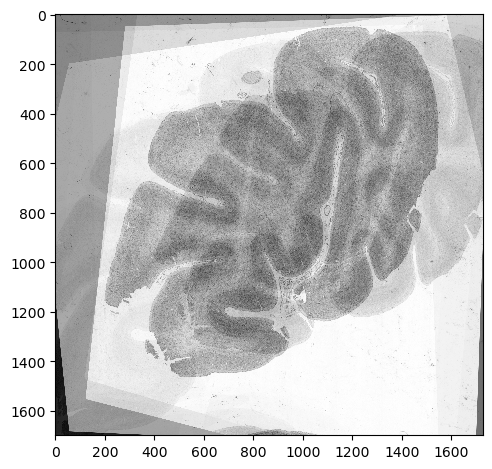

In [35]:
io.imshow(add_img[len(add_img)])